In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from scipy.optimize import fmin
import matplotlib.pyplot as plt

DATA IMPORT AND PROCESSING

In [3]:
# Charger les fichiers CSV
fedfunds = pd.read_csv('/Users/victor/Desktop/YC project/Real data/FEDFUNDS.csv')
mcumfn = pd.read_csv('/Users/victor/Desktop/YC project/Real data/MCUMFN.csv')
cpiaucsl = pd.read_csv('/Users/victor/Desktop/YC project/Real data/CPIAUCSL.csv')

# Convertir la colonne 'DATE' en datetime pour chaque DataFrame
fedfunds['DATE'] = pd.to_datetime(fedfunds['DATE'])
mcumfn['DATE'] = pd.to_datetime(mcumfn['DATE'])
cpiaucsl['DATE'] = pd.to_datetime(cpiaucsl['DATE'])

# Fusionner les DataFrames sur la colonne 'DATE'
macro_df = fedfunds.merge(mcumfn, on='DATE').merge(cpiaucsl, on='DATE')

# Afficher les premières lignes du DataFrame fusionné pour vérifier
print(macro_df)



          DATE  FEDFUNDS   MCUMFN  CPIAUCSL_PC1
0   2000-01-01      5.45  80.4586       2.79296
1   2000-02-01      5.73  80.3246       3.21797
2   2000-03-01      5.85  80.5324       3.76214
3   2000-04-01      6.02  80.7199       3.01386
4   2000-05-01      6.27  80.4263       3.13253
..         ...       ...      ...           ...
247 2020-08-01      0.10  74.0649       1.30060
248 2020-09-01      0.09  74.0997       1.37308
249 2020-10-01      0.09  74.8225       1.20317
250 2020-11-01      0.09  75.3804       1.16954
251 2020-12-01      0.09  76.0350       1.30495

[252 rows x 4 columns]


In [4]:
# Normaliser uniquement la colonne "MCUMFN" pour qu'elle commence à 1
# Ajouter une colonne "MCUMFN_base1" au DataFrame `macro_df`

macro_df['MCUMFN_base1'] = macro_df['MCUMFN'] / macro_df['MCUMFN'].iloc[0]
print(macro_df)

          DATE  FEDFUNDS   MCUMFN  CPIAUCSL_PC1  MCUMFN_base1
0   2000-01-01      5.45  80.4586       2.79296      1.000000
1   2000-02-01      5.73  80.3246       3.21797      0.998335
2   2000-03-01      5.85  80.5324       3.76214      1.000917
3   2000-04-01      6.02  80.7199       3.01386      1.003248
4   2000-05-01      6.27  80.4263       3.13253      0.999599
..         ...       ...      ...           ...           ...
247 2020-08-01      0.10  74.0649       1.30060      0.920534
248 2020-09-01      0.09  74.0997       1.37308      0.920967
249 2020-10-01      0.09  74.8225       1.20317      0.929950
250 2020-11-01      0.09  75.3804       1.16954      0.936884
251 2020-12-01      0.09  76.0350       1.30495      0.945020

[252 rows x 5 columns]


In [5]:
fed_rates= pd.read_csv('/Users/victor/Desktop/YC project/Real data/yield-curve-rates-2000_2020.csv',sep=";")

print(fed_rates)

fed_rates['Date'] = pd.to_datetime(fed_rates['Date'])

# Set the 'Date' column as the index
fed_rates.set_index('Date', inplace=True)

# Resample to get the first available data point for each month
fed_rates_monthly = fed_rates.resample('MS').first()

# Reset the index to make 'Date' a regular column again
fed_rates_monthly.reset_index(inplace=True)

fed_rates_monthly = fed_rates_monthly.drop(columns=["30 Yr"], errors='ignore')

# Check the result
print(fed_rates_monthly)

          Date  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr  30 Yr
0     12/31/20  0.09  0.09  0.10  0.13  0.17  0.36  0.65   0.93   1.45   1.65
1     12/30/20  0.08  0.09  0.12  0.12  0.17  0.37  0.66   0.93   1.46   1.66
2     12/29/20  0.10  0.12  0.11  0.12  0.17  0.37  0.66   0.94   1.47   1.67
3     12/28/20  0.11  0.11  0.11  0.13  0.17  0.38  0.65   0.94   1.46   1.67
4     12/24/20  0.09  0.09  0.10  0.13  0.17  0.37  0.66   0.94   1.46   1.66
...        ...   ...   ...   ...   ...   ...   ...   ...    ...    ...    ...
5249    1/7/00  5.38  5.66  6.00  6.31  6.35  6.42  6.58   6.52   6.82   6.55
5250    1/6/00  5.41  5.69  6.03  6.35  6.39  6.46  6.63   6.57   6.86   6.58
5251    1/5/00  5.44  5.74  6.05  6.38  6.43  6.51  6.68   6.62   6.95   6.64
5252    1/4/00  5.43  5.75  6.00  6.30  6.34  6.40  6.56   6.49   6.84   6.53
5253    1/3/00  5.48  5.81  6.09  6.38  6.42  6.50  6.65   6.58   6.94   6.61

[5254 rows x 11 columns]
          Date  3 Mo  6 Mo  1 Yr  2 Yr

In [6]:
#Slicing 2 randoms date 

sliced1= fed_rates_monthly.iloc[-1:]
sliced2= fed_rates_monthly.iloc[:1]

print(sliced1)
print(sliced2)


          Date  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr
251 2020-12-01  0.09   0.1  0.12  0.17  0.22  0.42  0.68   0.92   1.46
        Date  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr
0 2000-01-01  5.48  5.81  6.09  6.38  6.42   6.5  6.65   6.58   6.94


YIELD ONLY MODEL

In [25]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Assuming your DataFrame is named fed_rates_monthly and contains a Date column with yield columns for different maturities

# Nelson-Siegel function
def nelson_siegel(maturity, beta1, beta2, beta3, lambda_param):
    term1 = beta1
    term2 = beta2 * ((1 - np.exp(-maturity / lambda_param)) / (maturity / lambda_param))
    term3 = beta3 * (((1 - np.exp(-maturity / lambda_param)) / (maturity / lambda_param)) - np.exp(-maturity / lambda_param))
    return term1 + term2 + term3

# Objective function with a penalty for large jumps in Beta values
def ns_objective_penalized(params, prev_params, maturities, yields, alpha=0.01):
    beta1, beta2, beta3, lambda_param = params
    fitted_yields = nelson_siegel(maturities, beta1, beta2, beta3, lambda_param)
    fit_error = np.sum((yields - fitted_yields) ** 2)
    
    # Regularization term for smoothness (difference from previous parameters)
    smoothness_penalty = alpha * np.sum((np.array(params[:3]) - np.array(prev_params[:3])) ** 2)
    return fit_error + smoothness_penalty

# Define maturities in years (update this based on your columns in fed_rates_monthly)
maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20])  # Example maturities for 3 Mo, 6 Mo, 1 Yr, etc.

# Initialize dictionary to store parameters for each date
ns_params = {}

# Initial parameters (starting guess for optimization)
initial_params = [0.03, -0.02, 0.02, 1.0]
prev_params = initial_params  # Set previous parameters initially as the starting guess

# Define bounds for each parameter (beta1, beta2, beta3 constrained between -10 and 20, lambda unconstrained)
bounds = [(-10, 20), (-10, 20), (-10, 20), (None, None)]

# Fit the model for each date with penalized optimization
for date, row in fed_rates_monthly.iterrows():
    yields = row.values[1:]  # Exclude the date column
    try:
        result = minimize(ns_objective_penalized, prev_params, args=(prev_params, maturities, yields), method='L-BFGS-B', bounds=bounds)
        ns_params[date] = result.x  # Store the fitted parameters
        prev_params = result.x  # Update previous parameters for the next date
    except Exception as e:
        print(f"Optimization failed for date {date}: {e}")
        continue

# Convert ns_params into a DataFrame
ns_params_df = pd.DataFrame.from_dict(ns_params, orient='index', columns=['beta1', 'beta2', 'beta3', 'lambda'])
ns_params_df.index.name = 'DATE'

# Sort the DataFrame by date
ns_params_df.sort_index(inplace=True)

# Preview the smoothed beta parameters
print("Smoothed Nelson-Siegel Parameters:")
print(ns_params_df)




/var/folders/jd/4613gc0j4zn5jw0m55q_z42w0000gn/T/ipykernel_1489/1817340455.py:11: RuntimeWarning: overflow encountered in exp
  term2 = beta2 * ((1 - np.exp(-maturity / lambda_param)) / (maturity / lambda_param))
/var/folders/jd/4613gc0j4zn5jw0m55q_z42w0000gn/T/ipykernel_1489/1817340455.py:12: RuntimeWarning: overflow encountered in exp
  term3 = beta3 * (((1 - np.exp(-maturity / lambda_param)) / (maturity / lambda_param)) - np.exp(-maturity / lambda_param))
/var/folders/jd/4613gc0j4zn5jw0m55q_z42w0000gn/T/ipykernel_1489/1817340455.py:12: RuntimeWarning: invalid value encountered in subtract
  term3 = beta3 * (((1 - np.exp(-maturity / lambda_param)) / (maturity / lambda_param)) - np.exp(-maturity / lambda_param))


Optimization failed for date 14: (34, 'Result too large')
Smoothed Nelson-Siegel Parameters:
         beta1     beta2     beta3    lambda
DATE                                        
0     6.745390 -1.511416  0.012982  0.537225
1     6.738691 -1.601809  0.034049  0.278685
2     6.581005 -1.351563  0.041428  0.242622
3     6.329777 -1.309171  0.062063  0.117437
4     6.329777 -1.309171  0.062063  0.117437
...        ...       ...       ...       ...
247   1.780180 -1.657517 -2.012534  4.266472
248   1.900549 -1.750865 -2.288278  3.588101
249   2.047916 -1.928572 -2.277696  4.038703
250   2.105981 -1.986077 -2.302224  3.286964
251   2.130996 -2.020422 -2.286050  3.143631

[251 rows x 4 columns]


In [38]:
# Set the initial training window size
window_size = 120  #  120 months (10 years)

rolling_errors = []
for i in range(len(fed_rates_monthly) - window_size):
    # Split into train and test sets
    train_data = fed_rates_monthly.iloc[i:i+window_size]
    test_data = fed_rates_monthly.iloc[i+window_size:i+window_size+1]

    # Fit the model on the train set
    # (Repeat the parameter estimation code on train_data)

    # Calculate predictions for the test set
    test_date = test_data.index[0]
    test_yields = test_data.values[0][1:]
    fitted_yields = nelson_siegel(maturities, *ns_params_df.loc[test_date, ['beta1', 'beta2', 'beta3', 'lambda']])
    mse = mean_squared_error(test_yields, fitted_yields)
    mae = mean_absolute_error(test_yields, fitted_yields)
    rmse = np.sqrt(mse)
    rolling_errors.append([test_date, mse, mae, rmse])

rolling_errors_df = pd.DataFrame(rolling_errors, columns=['Date', 'MSE', 'MAE', 'RMSE'])
print(rolling_errors_df.describe())


             Date         MSE         MAE        RMSE
count  132.000000  132.000000  132.000000  132.000000
mean   185.500000    0.001153    0.026365    0.031366
std     38.249183    0.000928    0.011437    0.013060
min    120.000000    0.000127    0.008809    0.011288
25%    152.750000    0.000421    0.016783    0.020516
50%    185.500000    0.000789    0.023678    0.028084
75%    218.250000    0.001738    0.036566    0.041694
max    251.000000    0.004943    0.058198    0.070304


GRAPH CHECK

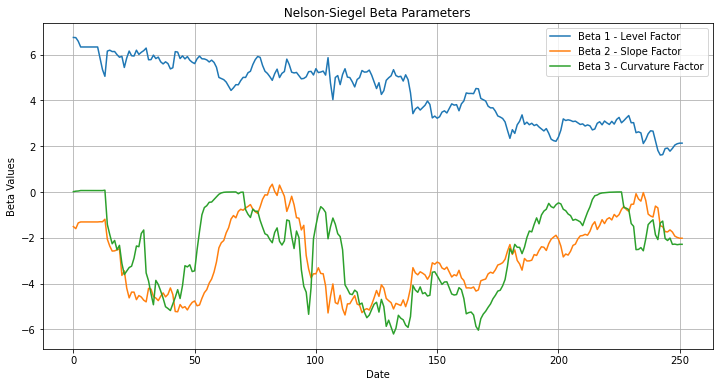

In [111]:
# Plot the smoothed Beta parameters over time
plt.figure(figsize=(12, 6))
plt.plot(ns_params_df.index, ns_params_df['beta1'], label='Beta 1 - Level Factor')
plt.plot(ns_params_df.index, ns_params_df['beta2'], label='Beta 2 - Slope Factor')
plt.plot(ns_params_df.index, ns_params_df['beta3'], label='Beta 3 - Curvature Factor')
plt.title(' Nelson-Siegel Beta Parameters ')
plt.xlabel('Date')
plt.ylabel('Beta Values')
plt.legend()
plt.grid(True)
plt.show()


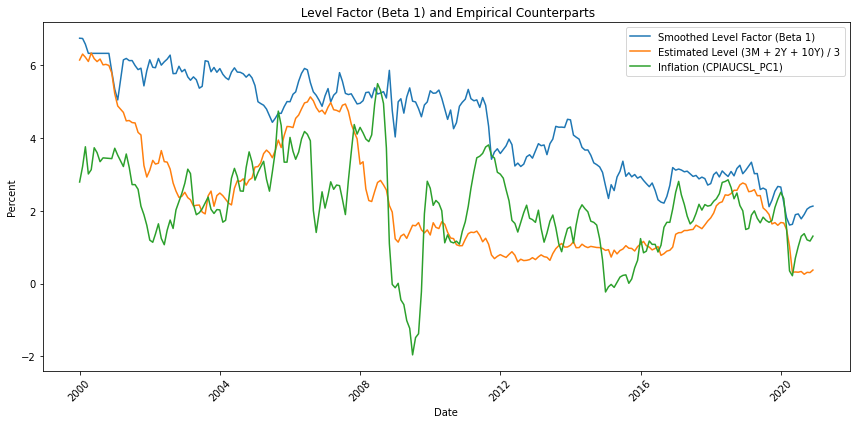

In [34]:
# Assuming `states_df`, `macro_df`, `ns_params_df`, and `fed_rates_monthly` are available

# Calculate the estimated level factor using 3M, 2Y, and 10Y yields from `fed_rates_monthly`
estimated_level = (fed_rates_monthly["3 Mo"] + fed_rates_monthly["2 Yr"] + fed_rates_monthly["10 Yr"]) / 3

# Merge ns_params_df (containing smoothed Beta values) with macro_df and fed_rates_monthly to align data on dates
ns_params_df['Date'] = fed_rates_monthly['Date']  # Ensure ns_params_df has the Date column for merging
merged_df = pd.merge(ns_params_df[['Date', 'beta1']], macro_df[['DATE', 'CPIAUCSL_PC1']], left_on='Date', right_on='DATE')

# Rename `beta1` as 'Smoothed Level Factor (Beta 1)'
merged_df.rename(columns={'beta1': 'Smoothed Level Factor (Beta 1)'}, inplace=True)

# Align lengths of `estimated_level` and `merged_df` by reindexing `estimated_level` to match `merged_df`
estimated_level_aligned = estimated_level.reindex(merged_df.index)

# Add the aligned estimated level factor to merged_df
merged_df['Estimated Level'] = estimated_level_aligned.values

# Plot Smoothed Level Factor (Beta 1), Estimated Level, and Inflation (CPIAUCSL_PC1)
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['Smoothed Level Factor (Beta 1)'], label='Smoothed Level Factor (Beta 1)')
plt.plot(merged_df['Date'], merged_df['Estimated Level'], label='Estimated Level (3M + 2Y + 10Y) / 3')
plt.plot(merged_df['Date'], merged_df['CPIAUCSL_PC1'], label='Inflation (CPIAUCSL_PC1)')
plt.title(' Level Factor (Beta 1) and Empirical Counterparts')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


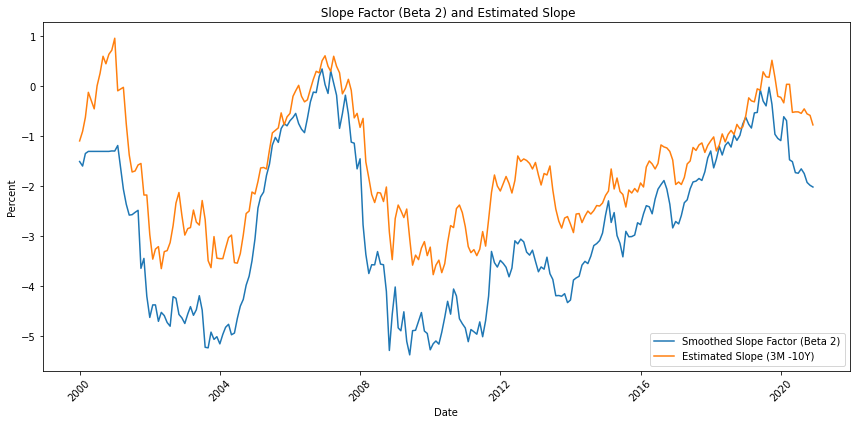

In [35]:


# Calculate the estimated slope factor using the difference between 10 Yr and 3 Mo yields
estimated_slope = fed_rates_monthly["3 Mo"] - fed_rates_monthly["10 Yr"]

# Merge ns_params_df (containing smoothed Beta values) with fed_rates_monthly to align data on dates
ns_params_df['Date'] = fed_rates_monthly['Date']  # Ensure ns_params_df has the Date column for merging
merged_df_slope = pd.merge(ns_params_df[['Date', 'beta2']], fed_rates_monthly[['Date']], on='Date')

# Rename `beta2` as 'Smoothed Slope Factor (Beta 2)'
merged_df_slope.rename(columns={'beta2': 'Smoothed Slope Factor (Beta 2)'}, inplace=True)

# Align lengths of `estimated_slope` and `merged_df_slope` by reindexing `estimated_slope` to match `merged_df_slope`
estimated_slope_aligned = estimated_slope.reindex(merged_df_slope.index)

# Add the aligned estimated slope to merged_df_slope
merged_df_slope['Estimated Slope'] = estimated_slope_aligned.values

# Plot Smoothed Slope Factor (Beta 2) and Estimated Slope
plt.figure(figsize=(12, 6))
plt.plot(merged_df_slope['Date'], merged_df_slope['Smoothed Slope Factor (Beta 2)'], label='Smoothed Slope Factor (Beta 2)')
plt.plot(merged_df_slope['Date'], merged_df_slope['Estimated Slope'], label='Estimated Slope (3M -10Y)')
plt.title(' Slope Factor (Beta 2) and Estimated Slope')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



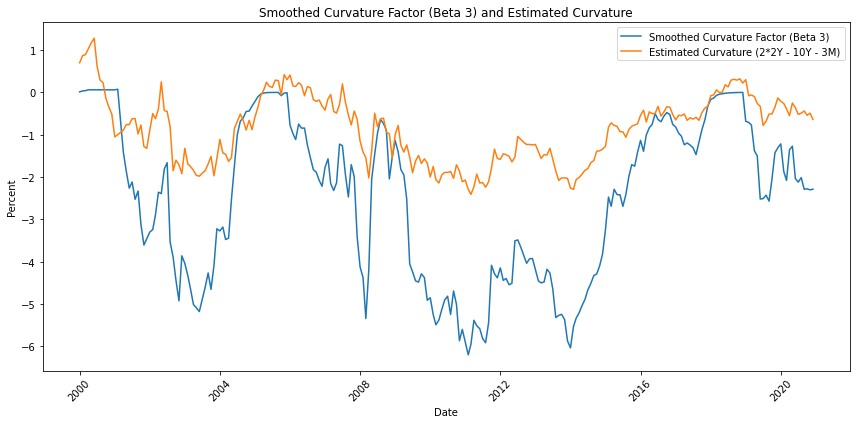

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `ns_params_df` and `fed_rates_monthly` are available

# Calculate the estimated curvature factor as 2*2Y - 10Y - 3M
estimated_curvature = 2 * fed_rates_monthly["2 Yr"] - fed_rates_monthly["10 Yr"] - fed_rates_monthly["3 Mo"]

# Merge ns_params_df (containing smoothed Beta values) with fed_rates_monthly to align data on dates
ns_params_df['Date'] = fed_rates_monthly['Date']  # Ensure ns_params_df has the Date column for merging
merged_df_curvature = pd.merge(ns_params_df[['Date', 'beta3']], fed_rates_monthly[['Date']], on='Date')

# Rename `beta3` as 'Smoothed Curvature Factor (Beta 3)'
merged_df_curvature.rename(columns={'beta3': 'Smoothed Curvature Factor (Beta 3)'}, inplace=True)

# Align lengths of `estimated_curvature` and `merged_df_curvature` by reindexing `estimated_curvature` to match `merged_df_curvature`
estimated_curvature_aligned = estimated_curvature.reindex(merged_df_curvature.index)

# Add the aligned estimated curvature to merged_df_curvature
merged_df_curvature['Estimated Curvature'] = estimated_curvature_aligned.values

# Plot Smoothed Curvature Factor (Beta 3) and Estimated Curvature
plt.figure(figsize=(12, 6))
plt.plot(merged_df_curvature['Date'], merged_df_curvature['Smoothed Curvature Factor (Beta 3)'], label='Smoothed Curvature Factor (Beta 3)')
plt.plot(merged_df_curvature['Date'], merged_df_curvature['Estimated Curvature'], label='Estimated Curvature (2*2Y - 10Y - 3M)')
plt.title('Smoothed Curvature Factor (Beta 3) and Estimated Curvature')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


LINEAR INTERPOLATION ON TWO RANDOM DATES (PREVIOUSLY SLICED)

Estimated Yields based on Nelson-Siegel Parameters for Sliced1 and Sliced2
   Maturity (Years)  Estimated Yields Sliced1  Estimated Yields Sliced2
0              0.25                  0.101533                  5.522291
1              0.50                  0.098918                  5.754024
2              1.00                  0.105706                  6.063215
3              2.00                  0.155728                  6.366827
4              3.00                  0.237235                  6.500643
5              5.00                  0.441263                  6.614509
6              7.00                  0.651598                  6.663797
7             10.00                  0.927461                  6.700778
8             20.00                  1.460524                  6.743921


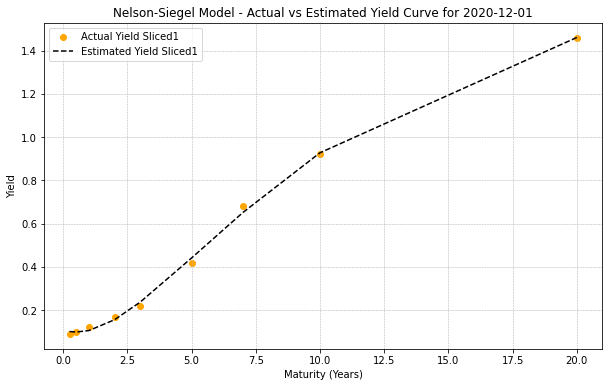

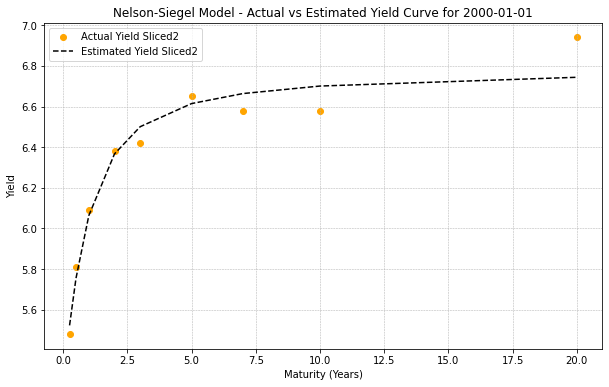

In [114]:
# Define the maturities in years
maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20])

# Nelson-Siegel function (using the estimated parameters)
def nelson_siegel(maturity, beta1, beta2, beta3, lambda_param):
    term1 = beta1
    term2 = beta2 * ((1 - np.exp(-maturity / lambda_param)) / (maturity / lambda_param))
    term3 = beta3 * (((1 - np.exp(-maturity / lambda_param)) / (maturity / lambda_param)) - np.exp(-maturity / lambda_param))
    return term1 + term2 + term3

# Nelson-Siegel parameters for sliced1 and sliced2 from the optimization results
ns_params_sliced1 = [2.138810, -2.029989, -2.278964, 3.173456]
ns_params_sliced2 = [6.787065, -1.575277, -0.000008, 0.547758]

# Calculate the estimated yields for each maturity using the fitted parameters
estimated_yields_sliced1 = [nelson_siegel(m, *ns_params_sliced1) for m in maturities]
estimated_yields_sliced2 = [nelson_siegel(m, *ns_params_sliced2) for m in maturities]

# Create DataFrames to display the estimated yields for each slice
estimated_yields_df = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Estimated Yields Sliced1': estimated_yields_sliced1,
    'Estimated Yields Sliced2': estimated_yields_sliced2
})

# Display the DataFrame
print("Estimated Yields based on Nelson-Siegel Parameters for Sliced1 and Sliced2")
print(estimated_yields_df)

import matplotlib.pyplot as plt

# Define the maturities and actual/estimated yields for Sliced1 and Sliced2
maturities = [0.25, 0.5, 1, 2, 3, 5, 7, 10, 20]
sliced1_actual_yields = [0.09, 0.1, 0.12, 0.17, 0.22, 0.42, 0.68, 0.92, 1.46]
sliced2_actual_yields = [5.48, 5.81, 6.09, 6.38, 6.42, 6.65, 6.58, 6.58, 6.94]
sliced1_estimated_yields = [0.101533, 0.098918, 0.105706, 0.155728, 0.237235, 0.441263, 0.651598, 0.927461, 1.460524]
sliced2_estimated_yields = [5.522291, 5.754024, 6.063215, 6.366827, 6.500643, 6.614509, 6.663797, 6.700778, 6.743921]

# Plot for Sliced1
plt.figure(figsize=(10, 6))
plt.scatter(maturities, sliced1_actual_yields, color='orange', label='Actual Yield Sliced1')
plt.plot(maturities, sliced1_estimated_yields, color='black', linestyle='--', label='Estimated Yield Sliced1')
plt.title("Nelson-Siegel Model - Actual vs Estimated Yield Curve for 2020-12-01")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Plot for Sliced2
plt.figure(figsize=(10, 6))
plt.scatter(maturities, sliced2_actual_yields, color='orange', label='Actual Yield Sliced2')
plt.plot(maturities, sliced2_estimated_yields, color='black', linestyle='--', label='Estimated Yield Sliced2')
plt.title("Nelson-Siegel Model - Actual vs Estimated Yield Curve for 2000-01-01")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


YIELD-MACRO  MODEL

In [86]:
fed_rates_monthly.rename(columns={"Date": "DATE", "date": "DATE"}, inplace=True)
macro_df.rename(columns={"Date": "DATE", "date": "DATE"}, inplace=True)
ns_params_df.rename(columns={"Date": "DATE", "date": "DATE"}, inplace=True)

In [87]:
print("Columns in fed_rates_monthly:", fed_rates_monthly.columns)
print("Columns in macro_df:", macro_df.columns)
print("Columns in ns_params_df:", ns_params_df.columns)

Columns in fed_rates_monthly: Index(['index', 'DATE', 'DATE', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr',
       '7 Yr', '10 Yr', '20 Yr'],
      dtype='object')
Columns in macro_df: Index(['index', 'DATE', 'FEDFUNDS', 'MCUMFN', 'CPIAUCSL_PC1', 'MCUMFN_base1'], dtype='object')
Columns in ns_params_df: Index(['beta1', 'beta2', 'beta3', 'lambda'], dtype='object')


In [89]:
# Remove duplicate 'DATE' columns in fed_rates_monthly
fed_rates_monthly = fed_rates_monthly.loc[:, ~fed_rates_monthly.columns.duplicated()]
print("Columns in fed_rates_monthly:", fed_rates_monthly.columns)


Columns in fed_rates_monthly: Index(['index', 'DATE', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr',
       '10 Yr', '20 Yr'],
      dtype='object')


In [95]:
import pandas as pd

# Step 1: Create a reference date range based on `fed_rates_monthly` or `macro_df`
full_dates = pd.to_datetime(macro_df['DATE'])  # Use the DATE column from either fed_rates_monthly or macro_df

# Step 2: Ensure `DATE` is set in `ns_params_df` and align it with `full_dates`
if 'DATE' not in ns_params_df.columns:
    ns_params_df['DATE'] = full_dates.values[:len(ns_params_df)]  # Add dates if missing

# Reindex `ns_params_df` to have the full set of dates, adding any missing date with NaN values
ns_params_df = ns_params_df.set_index('DATE').reindex(full_dates).reset_index()
ns_params_df.rename(columns={'index': 'DATE'}, inplace=True)  # Ensure column name consistency

# Step 3: Use forward fill (ffill) or backward fill (bfill) to fill missing values
ns_params_df.fillna(method='ffill', inplace=True)  # Use 'bfill' instead if you prefer backward fill

# Step 4: Convert 'DATE' columns to datetime format if they aren’t already
fed_rates_monthly['DATE'] = pd.to_datetime(fed_rates_monthly['DATE'])
macro_df['DATE'] = pd.to_datetime(macro_df['DATE'])
ns_params_df['DATE'] = pd.to_datetime(ns_params_df['DATE'])

# Step 5: Merge all DataFrames on the 'DATE' column
merged_df = pd.merge(fed_rates_monthly, macro_df, on='DATE', how='inner')
merged_df = pd.merge(merged_df, ns_params_df, on='DATE', how='inner')

# Check the final merged DataFrame
print("Merged DataFrame:")
print(merged_df.head())


Merged DataFrame:
   index_x       DATE  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr  \
0        0 2000-01-01  5.48  5.81  6.09  6.38  6.42  6.50  6.65   6.58   6.94   
1        1 2000-02-01  5.71  5.95  6.30  6.60  6.63  6.68  6.71   6.62   6.66   
2        2 2000-03-01  5.76  6.02  6.17  6.52  6.54  6.59  6.63   6.39   6.48   
3        3 2000-04-01  5.87  6.18  6.23  6.45  6.41  6.30  6.25   6.00   6.19   
4        4 2000-05-01  6.00  6.25  6.24  6.73  6.68  6.59  6.55   6.29   6.33   

   index_y  FEDFUNDS   MCUMFN  CPIAUCSL_PC1  MCUMFN_base1     beta1     beta2  \
0        0      5.45  80.4586       2.79296      1.000000  6.745390 -1.511416   
1        1      5.73  80.3246       3.21797      0.998335  6.738691 -1.601809   
2        2      5.85  80.5324       3.76214      1.000917  6.581005 -1.351563   
3        3      6.02  80.7199       3.01386      1.003248  6.329777 -1.309171   
4        4      6.27  80.4263       3.13253      0.999599  6.329777 -1.309171   

      be

In [96]:
# Define the extended NS 

import numpy as np
from scipy.optimize import minimize

# Define the extended Nelson-Siegel model with macro factors
def nelson_siegel_macro(params, maturities, macro_factors):
    """
    params: array of parameters [beta1, beta2, beta3, lambda, macro_weight1, macro_weight2, macro_weight3]
    maturities: array of maturities in years
    macro_factors: array of macroeconomic factor values (aligned by date)
    """
    beta1, beta2, beta3, lambda_, macro_weight1, macro_weight2, macro_weight3 = params
    
    # Nelson-Siegel formula for yield curve
    yield_curve = (beta1 +
                   beta2 * ((1 - np.exp(-maturities / lambda_)) / (maturities / lambda_)) +
                   beta3 * (((1 - np.exp(-maturities / lambda_)) / (maturities / lambda_)) - np.exp(-maturities / lambda_)))
    
    # Add macro influences
    macro_contribution = (macro_weight1 * macro_factors[0] +
                          macro_weight2 * macro_factors[1] +
                          macro_weight3 * macro_factors[2])
    
    return yield_curve + macro_contribution


In [97]:
# Define the objective function

def objective_function(params, prev_params, maturities, observed_yields, macro_factors, alpha=0.01):
    """
    params: current parameters being optimized
    prev_params: parameters from the previous time step
    maturities: array of maturities in years
    observed_yields: observed yield values for each maturity
    macro_factors: array of macroeconomic factor values for the current date
    alpha: smoothness penalty weight
    """
    # Calculate estimated yields
    estimated_yields = nelson_siegel_macro(params, maturities, macro_factors)
    
    # Calculate fit error
    fit_error = np.sum((observed_yields - estimated_yields) ** 2)
    
    # Smoothness penalty on parameter changes
    smoothness_penalty = alpha * np.sum((np.array(params[:4]) - np.array(prev_params[:4])) ** 2)
    
    return fit_error + smoothness_penalty



In [98]:
# Define maturities in years (adjust this based on your yield columns)
maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20])  # Example maturities for 3 Mo, 6 Mo, 1 Yr, etc.

# Initialize dictionary to store estimated parameters for each date
estimated_params = {}

# Initial parameters (starting guesses)
initial_params = [0.03, -0.02, 0.02, 1.0, 0.1, 0.1, 0.1]  # Initial guess for [beta1, beta2, beta3, lambda, macro_weights]
prev_params = initial_params  # Set initial previous parameters

# Optimization bounds
bounds = [(-10, 10), (-10, 10), (-10, 10), (0.01, 10), (-10, 10), (-10, 10), (-10, 10)]

# Loop through each date in `merged_df` to estimate parameters
for index, row in merged_df.iterrows():
    # Extract observed yields and macro factors for the current date
    observed_yields = row[['3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr']].values
    macro_factors = row[['FEDFUNDS', 'MCUMFN', 'CPIAUCSL_PC1']].values  # Adjust based on actual column names

    # Optimize parameters for the current date
    result = minimize(objective_function, initial_params, args=(prev_params, maturities, observed_yields, macro_factors),
                      method='L-BFGS-B', bounds=bounds)
    
    # Store the estimated parameters
    estimated_params[row['DATE']] = result.x
    prev_params = result.x  # Update previous parameters for smoothness in the next period

# Convert estimated_params into a DataFrame
estimated_params_df = pd.DataFrame.from_dict(estimated_params, orient='index',
                                             columns=['beta1', 'beta2', 'beta3', 'lambda', 'macro_weight1', 'macro_weight2', 'macro_weight3'])
estimated_params_df.index.name = 'DATE'

# Display the estimated parameters
print("Estimated Parameters with Macro Factors:")
print(estimated_params_df.head())


Estimated Parameters with Macro Factors:
               beta1     beta2     beta3    lambda  macro_weight1  \
DATE                                                                
2000-01-01  0.033391 -1.492011  0.079587  0.655971       0.203614   
2000-02-01  0.034203 -1.398996  1.030545  0.636620      -0.100944   
2000-03-01  0.223175 -0.920818  1.525628  1.079940       0.114886   
2000-04-01  0.223679 -0.399281  1.837997  0.884634       0.409873   
2000-05-01  0.577406 -0.379508  2.210829  1.335829       0.562371   

            macro_weight2  macro_weight3  
DATE                                      
2000-01-01       0.064896       0.150119  
2000-02-01       0.094640      -0.109597  
2000-03-01       0.063505       0.115851  
2000-04-01       0.025624       0.424289  
2000-05-01       0.002831       0.585819  


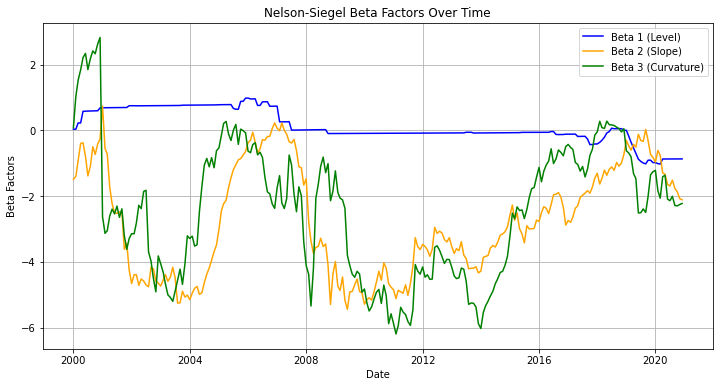

In [100]:
import matplotlib.pyplot as plt

# Ensure the 'DATE' index is in datetime format for proper plotting
estimated_params_df.index = pd.to_datetime(estimated_params_df.index)

# Plot the three beta factors together
plt.figure(figsize=(12, 6))
plt.plot(estimated_params_df.index, estimated_params_df['beta1'], label='Beta 1 (Level)', color='blue')
plt.plot(estimated_params_df.index, estimated_params_df['beta2'], label='Beta 2 (Slope)', color='orange')
plt.plot(estimated_params_df.index, estimated_params_df['beta3'], label='Beta 3 (Curvature)', color='green')

# Add titles and labels
plt.title('Nelson-Siegel Beta Factors Over Time')
plt.xlabel('Date')
plt.ylabel('Beta Factors')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


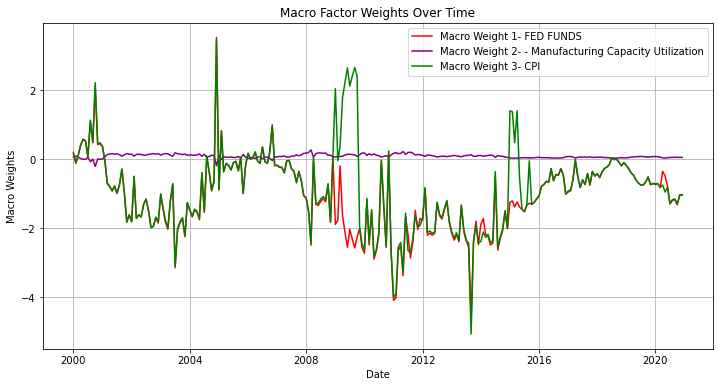

In [116]:
import matplotlib.pyplot as plt

# Ensure the 'DATE' index is in datetime format for proper plotting
estimated_params_df.index = pd.to_datetime(estimated_params_df.index)

# Plot the three macro weights together
plt.figure(figsize=(12, 6))
plt.plot(estimated_params_df.index, estimated_params_df['macro_weight1'], label='Macro Weight 1- FED FUNDS', color='red')
plt.plot(estimated_params_df.index, estimated_params_df['macro_weight2'], label='Macro Weight 2- - Manufacturing Capacity Utilization', color='purple')
plt.plot(estimated_params_df.index, estimated_params_df['macro_weight3'], label='Macro Weight 3- CPI', color='green')

# Add titles and labels
plt.title('Macro Factor Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Macro Weights')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [110]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import minimize
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Define the Nelson-Siegel function with macro factors
def nelson_siegel_macro(params, maturities, macro_factors):
    beta1, beta2, beta3, lambda_, macro_weight1, macro_weight2, macro_weight3 = params
    yield_curve = (beta1 +
                   beta2 * ((1 - np.exp(-maturities / lambda_)) / (maturities / lambda_)) +
                   beta3 * (((1 - np.exp(-maturities / lambda_)) / (maturities / lambda_)) - np.exp(-maturities / lambda_)))
    macro_contribution = (macro_weight1 * macro_factors[0] +
                          macro_weight2 * macro_factors[1] +
                          macro_weight3 * macro_factors[2])
    return yield_curve + macro_contribution

# Objective function
def objective_function(params, maturities, observed_yields, macro_factors):
    estimated_yields = nelson_siegel_macro(params, maturities, macro_factors)
    return np.sum((observed_yields - estimated_yields) ** 2)

# Define the maturities in years
maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20])  # Example maturities for 3 Mo, 6 Mo, 1 Yr, etc.
window_size = 120  # 10 years of monthly data

# Function to perform rolling estimation for a single window
def rolling_estimation(i):
    # Define train and test data for this window
    train_data = merged_df.iloc[i:i+window_size]
    test_data = merged_df.iloc[i+window_size:i+window_size+1]
    
    # Extract train yields and macro factors
    train_yields = train_data[['3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr']].values
    train_macro = train_data[['FEDFUNDS', 'MCUMFN', 'CPIAUCSL_PC1']].values

    # Initial parameters
    initial_params = [0.03, -0.02, 0.02, 1.0, 0.1, 0.1, 0.1]
    bounds = [(-10, 10), (-10, 10), (-10, 10), (0.01, 10), (-10, 10), (-10, 10), (-10, 10)]

    # Fit the model on the train set using a single optimization
    result = minimize(objective_function, initial_params, args=(maturities, train_yields.mean(axis=0), train_macro.mean(axis=0)), 
                      method='L-BFGS-B', bounds=bounds)
    
    # Test the fitted model on the test set
    test_yields = test_data[['3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr']].values[0]
    test_macro_factors = test_data[['FEDFUNDS', 'MCUMFN', 'CPIAUCSL_PC1']].values[0]
    fitted_yields = nelson_siegel_macro(result.x, maturities, test_macro_factors)
    
    # Calculate errors
    mse = mean_squared_error(test_yields, fitted_yields)
    mae = mean_absolute_error(test_yields, fitted_yields)
    rmse = np.sqrt(mse)
    
    return [test_data['DATE'].values[0], mse, mae, rmse]

# Run rolling estimation in parallel
rolling_errors = Parallel(n_jobs=-1)(delayed(rolling_estimation)(i) for i in range(len(merged_df) - window_size))

# Convert results to a DataFrame
rolling_errors_df = pd.DataFrame(rolling_errors, columns=['Date', 'MSE', 'MAE', 'RMSE'])

# Display the rolling errors summary
print(rolling_errors_df.describe())




              MSE         MAE        RMSE
count  132.000000  132.000000  132.000000
mean    25.213979    4.603183    4.635321
std     17.618744    1.957750    1.938101
min      0.206241    0.413279    0.454138
25%      9.049752    2.955519    3.008173
50%     23.896804    4.879454    4.888393
75%     36.675905    6.025445    6.056027
max     76.367868    8.736094    8.738871
